## Auto ARIMA
When fitting an ARIMA model, we need to make the series stationary and determine the values of our parameters p,d and q which optimise a certain metric. There are many methods to achieve this goal and yet the correct parametrization of ARIMA models can be a tedious process that requires statistical expertise and time. In this article, we hope to overcome this issue by writing ‘a grid search’ algorithm using auto ARIMA in Python, which automatically selects the best combination of (p, d, q) that provides the least error.

reference: 
https://nzlul.medium.com/stock-price-prediction-using-auto-arima-5569fcceae59
https://www.youtube.com/watch?v=gqryqIlvEoM
https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/#h2_3
https://towardsdatascience.com/which-evaluation-metric-should-you-use-in-machine-learning-regression-problems-20cdaef258e

## Goals
The goal is to train an ARIMA model with optimal parameters that will forecast the closing price of the stocks on the test data.

### Step 1. Importing Required Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

#Data Manipulation and Treatment
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from math import sqrt
import math


#Plotting and Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# render the figures in this notebook 
%matplotlib inline
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Scikit-Learn for Modeling
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

#Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#from pmdarima import auto_arima

# Data reader

from pandas_datareader import data
from typing import Dict, List, Any
from matplotlib.ticker import FuncFormatter


### Step 2. Loading the Dataset
The dataset consists of stock market data of Apple Inc. and it can be downloaded from Yahoo Finance. The data shows the stock price of Apple Inc from 2019–01–01 till 2020–12–31. We choose the closing value for this analysis.

In [3]:
# Input tickers here
tickers = ['AAPL']
start_date = '2019-01-01'
end_date = '2020-12-31'

# User pandas_reader.data.DataReader to load data
df = data.DataReader(tickers, 'yahoo', start_date, end_date)
df.head()


RemoteDataError: ignored

In [ ]:
df.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=506, freq=None)

In [ ]:
df.isnull().sum()

Attributes  Symbols
Adj Close   AAPL       0
Close       AAPL       0
High        AAPL       0
Low         AAPL       0
Open        AAPL       0
Volume      AAPL       0
dtype: int64

### Step 3. Visualizing the Data

In [ ]:
fig = px.line(df['Close'])

fig.update_layout(title_text='Stock Prices of APPLE',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Close")
fig.show()

<AxesSubplot:title={'center':'Stock Close Prices of Apple'}, xlabel='Date'>

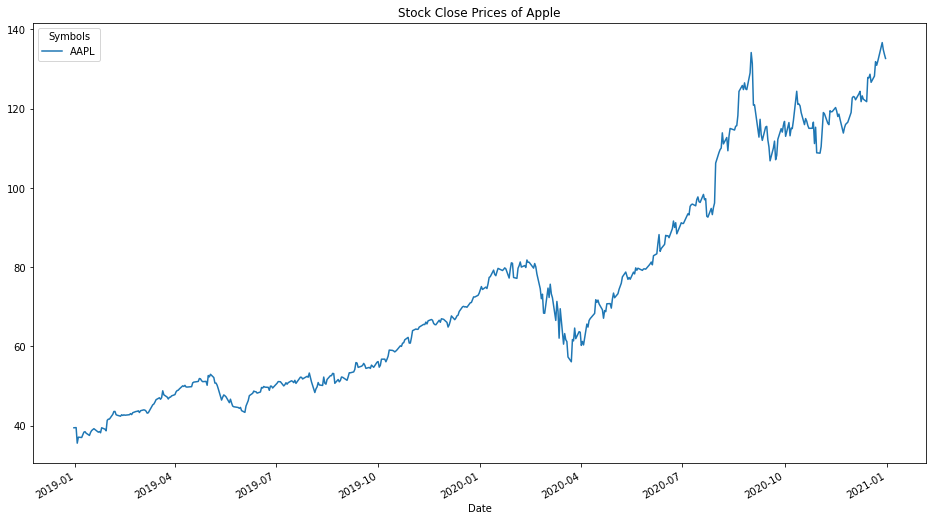

In [ ]:
df['Close'].plot(figsize=(16,9), title = 'Stock Close Prices of Apple')

### Step 4. Test For the Stationarity (mean-reversion)

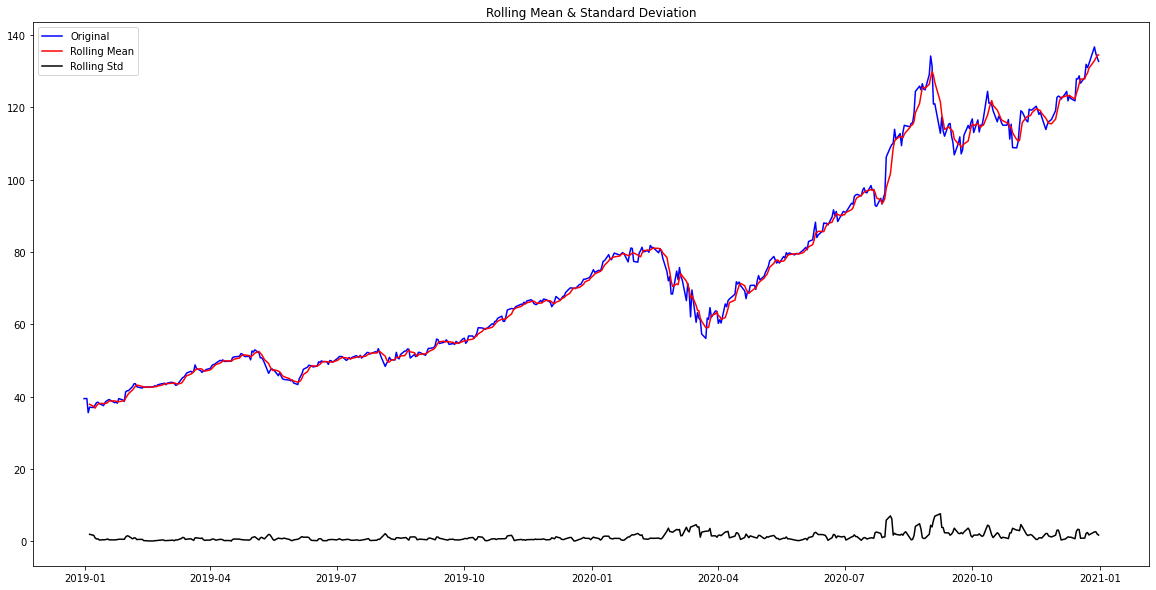

Results of Dickey-Fuller Test:
Test Statistic                   0.297888
p-value                          0.977247
#Lags Used                       9.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (5%)             -2.867385
Critical Value (10%)            -2.569883
dtype: float64
result : time series is not stationary


In [ ]:
# Checking Stasionarity - Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(4).mean() # around 4 weeks on each month
    rolstd = timeseries.rolling(4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print('result : time series is stationary')
    else : print('result : time series is not stationary')
        
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(df['Close'])

#### NOTE:
The p-value obtained is greater than the significance level of 0.05, and the ADF test statistic is greater than any of the critical values. There is no reason to reject the null hypothesis. So, the time series is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

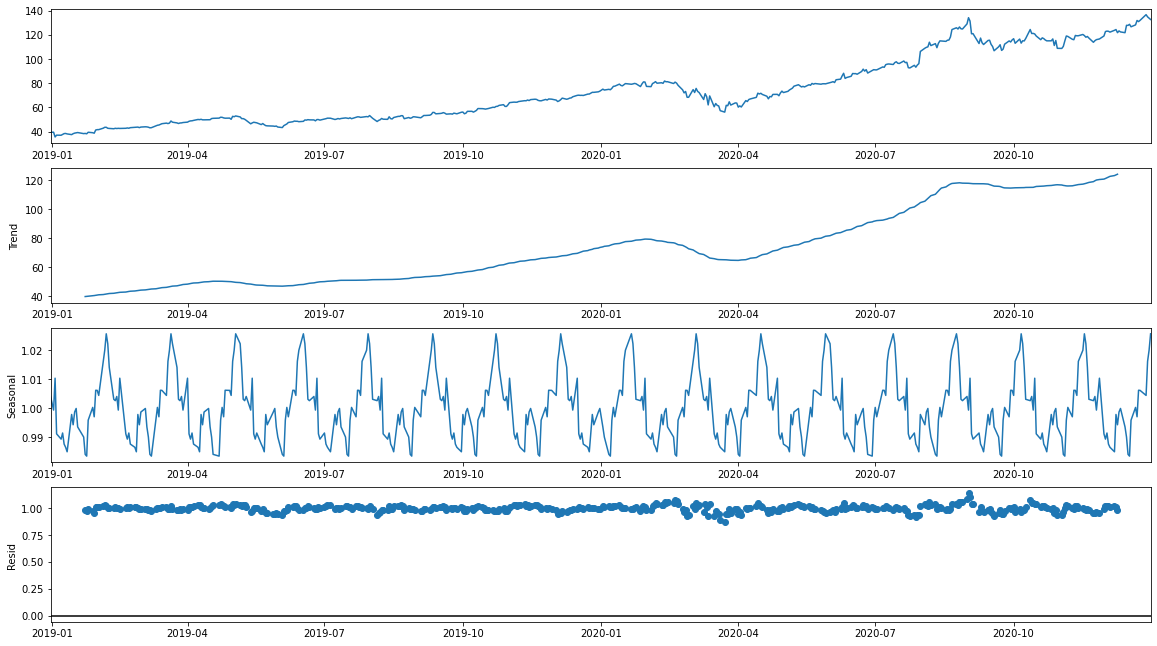

In [ ]:
# Checking Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(df['Close'],model='multiplicative', freq=30)
fig = decomposition.plot()  
fig.set_size_inches(16, 9)

# trend = decomposition.trend 
# seasonal = decomposition.seasonal 
# residual = decomposition.resid

# plt.subplot(411) 
# plt.plot(df, label='Original') 
# plt.legend(loc='best') 

# plt.subplot(412) 
# plt.plot(trend, label='Trend') 
# plt.legend(loc='best') 

# plt.subplot(413) 
# plt.plot(seasonal,label='Seasonality') 
# plt.legend(loc='best') 

# plt.subplot(414) 
# plt.plot(residual, label='Residuals') 
# plt.legend(loc='best')

# plt.tight_layout() 
# plt.show()

### 5. Fitting auto ARIMA model
Now, create an auto ARIMA model and train it with the closing price of the stock on the train data. So let us split the data into training and test set. 

In [ ]:
#train size = 80% of the dataset
model_train=df.iloc[:int(df.shape[0]*0.80)]

#test size = 20% 
valid=df.iloc[int(df.shape[0]*0.80):]

y_pred=valid.copy()
model_train.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2018-12-31,38.338482,39.435001,39.840000,39.119999,39.632500,140014000.0
2019-01-02,38.382225,39.480000,39.712502,38.557499,38.722500,148158800.0
2019-01-03,34.559074,35.547501,36.430000,35.500000,35.994999,365248800.0
2019-01-04,36.034378,37.064999,37.137501,35.950001,36.132500,234428400.0
2019-01-07,35.954170,36.982498,37.207500,36.474998,37.174999,219111200.0


In [ ]:
model_train.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06'],
              dtype='datetime64[ns]', name='Date', length=404, freq=None)

After that, we choosing the parameters of p, d and q for ARIMA model. We are going to use Auto-ARIMA to get the best parameters without even plotting ACF and PACF graphs.
In the auto ARIMA model, note that small p, d, q values represent non-seasonal. Next, we are trying with the p, d, q values ranging from 1 to 3. 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1510.507, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1496.042, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1493.860, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1495.812, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1493.357, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1494.455, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1495.391, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1497.316, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1494.136, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1494.682, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1496.512, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1499.110, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1495.700, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1496.497, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1483.763, Time=0.59 sec

Best mode

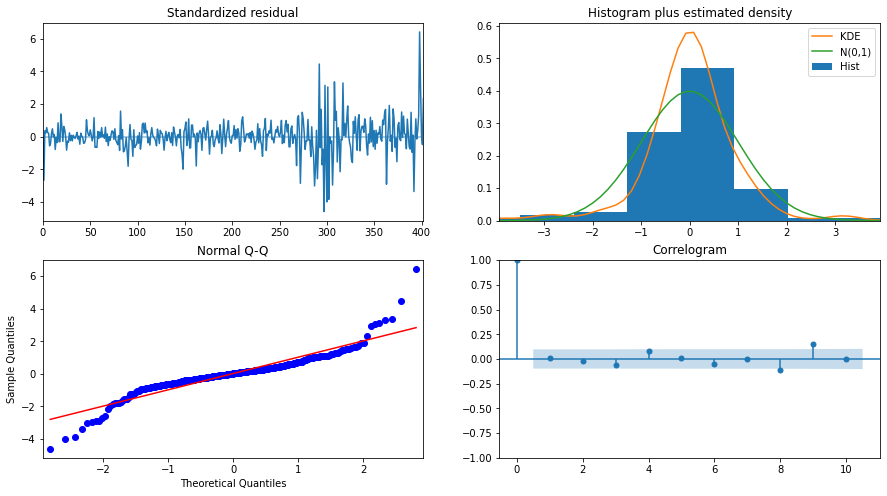

In [ ]:
# model_scores_r2=[]
# model_scores_mse=[]
# model_scores_rmse=[]
# model_scores_mae=[]
# model_scores_rmsle=[]

#train model
model_arima= auto_arima(model_train["Close"],trace=True, error_action='ignore', 
              start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model_arima.fit(model_train["Close"],order=(3, 1, 2),disp=-1)
print(model_arima.summary())
 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  404
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -734.882
Date:                Tue, 19 Oct 2021   AIC                           1483.763
Time:                        20:26:32   BIC                           1511.756
Sample:                             0   HQIC                          1494.845
                                - 404                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1635      0.106      1.540      0.123      -0.045       0.372
ar.L1         -0.6912      0.231     -2.987      0.003      -1.145      -0.238
ar.L2          0.3803      0.257      1.482      0.1

So the Auto-ARIMA model provided the value of p, d and q as 2, 1 and 2 respectively.

### 5. Forecasting the Data
Using the trained model which was built in the earlier step to forecast the sales on the test data.

In [ ]:
# Forecast

prediction_arima=model_arima.predict(len(valid),alpha=0.05) # 95% confidence
y_pred["ARIMA Model Prediction"]=prediction_arima


# #plot
# plt.plot(model_train['Close'])
# plt.plot(valid['Close'])
# plt.plot(y_pred["ARIMA Model Prediction"])


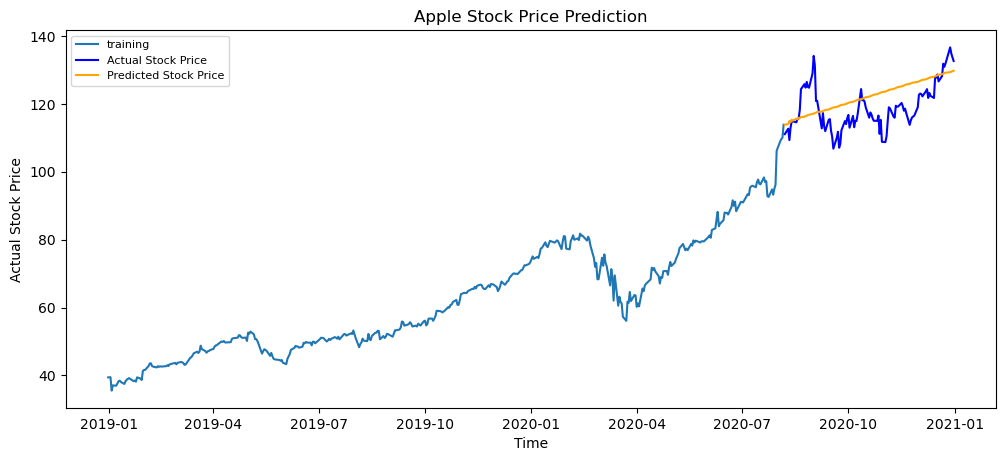

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(model_train['Close'], label='training')
plt.plot(valid['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(y_pred["ARIMA Model Prediction"], color = 'orange',label='Predicted Stock Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:

r2_arima= r2_score(y_pred["Close"],y_pred["ARIMA Model Prediction"])
mse_arima= mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
rmse_arima=sqrt(mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))
mae_arima=mean_absolute_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
#rmsle_arima = np.sqrt(mean_squared_log_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))


#model_scores_r2.append(r2_arima)
#model_scores_mse.append(mse_arima)
#model_scores_rmse.append(rmse_arima)
#model_scores_mae.append(mae_arima)
#model_scores_rmsle.append(rmsle_arima)


print("R Square Score ARIMA: ",r2_arima)
print("Mean Square Error ARIMA: ",mse_arima)
print("Root Mean Square Error ARIMA: ",rmse_arima)
print("Mean Absoulute Error ARIMA: ",mae_arima)
#print("Root Mean Squared Logarithmic Error ARIMA: ", rmsle_arima)

R Square Score ARIMA:  -0.07198453013364148
Mean Square Error ARIMA:  48.33146143862778
Root Mean Square Error ARIMA:  6.952083244512236
Mean Absoulute Error ARIMA:  5.8690002919921405


Calculate RMSE: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set

An auto-ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. As its evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part.

In [ ]:
#last day of the dataset: 2020-12-31

ARIMA_model_new_date=[]
ARIMA_model_new_prediction=[]

for i in range(1,15):
     ARIMA_model_new_date.append(df.index[-1]+timedelta(days=i))
     ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
    
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(ARIMA_model_new_date,ARIMA_model_new_prediction), columns=["Dates","ARIMA Model Prediction"])
model_predictions

,Dates,ARIMA Model Prediction
0,2021-01-01,129.984562
1,2021-01-02,130.135251
2,2021-01-03,130.285939
3,2021-01-04,130.436627
4,2021-01-05,130.587315
5,2021-01-06,130.738004
6,2021-01-07,130.888692
7,2021-01-08,131.039380
8,2021-01-09,131.190069
9,2021-01-10,131.340757


Note: 
There is no such thing as a good RMSE, because it is scale-dependent, i.e. dependent on your dependent variable. Hence one can not claim a universal number as a good RMSE.

2-Convert the end result (df table) to json

Common data model

{
  meta: {
    table_name: string,
    column_names: Array<string>,  
    }
  data: [
    {row1},
    {row2}
    ]
}

In [ ]:
import json
import datetime

In [ ]:
#result = model_predictions.to_json('temp.json', orient='records', lines=True)


result = model_predictions.to_json(orient="values")
print(result)
#parsed = json.loads(result)


[[1609459200000,129.9845622343],[1609545600000,130.1352505258],[1609632000000,130.2859388203],[1609718400000,130.4366271123],[1609804800000,130.5873154064],[1609891200000,130.7380036988],[1609977600000,130.8886919925],[1610064000000,131.0393802852],[1610150400000,131.1900685787],[1610236800000,131.3407568715],[1610323200000,131.491445165],[1610409600000,131.6421334579],[1610496000000,131.7928217512],[1610582400000,131.9435100442]]


In [ ]:
{
  meta: {
    table_name: string,
    column_names: Array<string>,  
    }
  data: [
    {row1},
    {row2}
    ]
}